# Task 4: Game Title Detection
Problem: Customer support receives 2,000 daily tickets with images, wasting 10+ minutes figuring out which game before routing to specialists. The "Play Multiple Games for Rewards" campaign can't verify 50,000+ screenshot submissions, forcing manual checks of only 3%.

Your Task: Build an image classifier identifying which game is being played from screenshots:

- Class 0: PUBE Mobile
- Class 1: Free Fried
- Class 2: FiveN
- Class 3: Roblock
- Class 4: 7-Eleven Knight
Metric: F₁ Score (Macro)

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers, optimizers, callbacks, mixed_precision
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [10]:
# Mixed Precision Check for GPU support

try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed Precision enabled")
except Exception as e:
    print("Mixed precision not available, skipping.")

Mixed Precision enabled


In [11]:
# Global Variables

TRAIN_IMG_PATH = './train/' 
VAL_IMG_PATH   = './val/'
TEST_IMG_PATH  = './test/'

BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 12
IMG_SIZE = 224
N_FOLDS = 5
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
# Data Loading

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
submission_df = pd.read_csv('test_refined.csv')


# Add image paths to dataframes
train_df['image_path'] = TRAIN_IMG_PATH + train_df['file_name']
val_df['image_path'] = VAL_IMG_PATH + val_df['file_name']
submission_df['image_path'] = TEST_IMG_PATH + submission_df['file_name']

print(f"Original Val Size: {len(val_df)}")

Original Val Size: 24772


In [ ]:
# Helper Functions

# Load image and label from path and preprocess for training
def load_and_preprocess(file_path, label=None, is_train=False):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    
    if is_train:
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    img = preprocess_input(img)

    if label is not None:
        return img, label
    else:
        return img

def create_dataset(df, is_train=False, is_test=False):
    paths = df['image_path'].values
    if is_test:
        ds = tf.data.Dataset.from_tensor_slices(paths)
        ds = ds.map(lambda x: load_and_preprocess(x, label=None, is_train=False), num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    else:
        labels = df['label'].astype(int).values
        labels = tf.one_hot(labels, NUM_CLASSES)
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        if is_train:
            ds = ds.shuffle(1000)
            ds = ds.map(lambda x, y: load_and_preprocess(x, y, is_train=True), num_parallel_calls=AUTOTUNE)
        else:
            ds = ds.map(lambda x, y: load_and_preprocess(x, y, is_train=False), num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

class ValF1Logger(callbacks.Callback):
    def __init__(self, val_ds, val_labels):
        super().__init__()
        self.val_ds = val_ds
        self.val_labels = val_labels

    def on_epoch_end(self, epoch, logs=None):
        # Calculate F1 Macro Score at end of epoch
        val_pred = np.argmax(self.model.predict(self.val_ds, verbose=0), axis=1)
        score = f1_score(self.val_labels, val_pred, average='macro')
        
        # Add to logs so we can plot it later
        logs['val_f1'] = score
        print(f" - val_f1: {score:.4f}")

def plot_f1_performance(histories):
    f1_list = [h['val_f1'] for h in histories]
    loss_list = [h['val_loss'] for h in histories]
    min_len = min([len(x) for x in f1_list])
    epochs = range(1, min_len + 1)
    
    mean_f1 = np.mean([x[:min_len] for x in f1_list], axis=0)
    mean_loss = np.mean([x[:min_len] for x in loss_list], axis=0)

    plt.figure(figsize=(16, 6))
    
    # Plot F1 Macro Score
    plt.subplot(1, 2, 1)
    for f1 in f1_list:
        plt.plot(f1[:min_len], color='green', alpha=0.15)
    plt.plot(epochs, mean_f1, 'g-', linewidth=2, label='Mean Val F1 Score')
    plt.title(f'Cross-Validation F1 Score (Peak: {np.max(mean_f1):.4f})')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for l in loss_list:
        plt.plot(l[:min_len], color='red', alpha=0.15)
    plt.plot(epochs, mean_loss, 'r-', linewidth=2, label='Mean Val Loss')
    plt.title('Cross-Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [14]:
# Dataset Creation
train_ds = create_dataset(train_df)
val_ds   = create_dataset(val_df)
test_ds = create_dataset(submission_df, is_test=True)

print(f"Train Dataset Size: {len(train_ds)}")
print(f"Val Dataset Size:   {len(val_ds)}")
print(f"Test Dataset Size:  {len(test_ds)}")

Train Dataset Size: 986
Val Dataset Size:   775
Test Dataset Size:  810


In [15]:
# Cross Validation

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_histories = []
test_predictions_sum = np.zeros((len(submission_df), NUM_CLASSES))

X = train_df['image_path']
y = train_df['label']

In [ ]:
# Model Compile and Training
print(f"Starting {N_FOLDS}-Fold CV with VGG19")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}/{N_FOLDS}")
    
    fold_train_df = train_df.iloc[train_idx]
    fold_val_df = train_df.iloc[val_idx]
    val_labels_fold = fold_val_df['label'].values
    
    train_ds = create_dataset(fold_train_df, is_train=True)
    val_ds = create_dataset(fold_val_df, is_train=False)
    
    # Build Model using VGG19 with ImageNet weights
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False 
    
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    f1_logger = ValF1Logger(val_ds, val_labels_fold)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    print("Training Head")
    h1 = model.fit(train_ds, validation_data=val_ds, epochs=6, 
                   callbacks=[f1_logger, reduce_lr, early_stop], verbose=1)
    
    # Fine-Tuning by Freezing Layers and Unfreezing Last 5 Layers
    print("Fine-Tuning")
    base_model.trainable = True
    for layer in base_model.layers[:-5]: layer.trainable = False
    model.compile(optimizer=optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    h2 = model.fit(train_ds, validation_data=val_ds, epochs=8, 
                   callbacks=[f1_logger, reduce_lr, early_stop], verbose=1)
    
    # Merge Histories
    combined = {}
    for k in h1.history.keys():
        combined[k] = h1.history[k] + h2.history[k]
    fold_histories.append(combined)
    
    # Predict with Test Dataset
    test_predictions_sum += model.predict(test_ds, verbose=0)
    
    # Cleanup before next fold
    del model, base_model, train_ds, val_ds
    tf.keras.backend.clear_session()

Starting 5-Fold CV with VGG19 (Tracking Macro F1)...

--- FOLD 1/5 ---
  Training Head...
Epoch 1/6


2025-11-24 20:02:42.152584: I external/local_xla/xla/service/service.cc:163] XLA service 0x77dab00233f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 20:02:42.152606: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-11-24 20:02:42.218355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 20:02:42.529842: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-24 20:02:44.569604: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng4{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[32,224,224,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,224,224,3]{3,2,1,0}, f16[64,3,3,3]{3,2,1,0}, f16[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__c

  3/789 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.2101 - loss: 2.5296 

I0000 00:00:1763989372.622916   31850 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5376 - loss: 1.3270

2025-11-24 20:03:58.643944: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


 - val_f1: 0.7267
789/789 ━━━━━━━━━━━━━━━━━━━━ 90s 99ms/step - accuracy: 0.6077 - loss: 1.0935 - val_accuracy: 0.7539 - val_loss: 0.6802 - val_f1: 0.7267 - learning_rate: 0.0010
Epoch 2/6
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6714 - loss: 0.8594 - val_f1: 0.7440
789/789 ━━━━━━━━━━━━━━━━━━━━ 69s 88ms/step - accuracy: 0.6806 - loss: 0.8434 - val_accuracy: 0.7724 - val_loss: 0.6443 - val_f1: 0.7440 - learning_rate: 0.0010
Epoch 3/6
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6983 - loss: 0.7962 - val_f1: 0.7569
789/789 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.7052 - loss: 0.7845 - val_accuracy: 0.7851 - val_loss: 0.6135 - val_f1: 0.7569 - learning_rate: 0.0010
Epoch 4/6
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7122 - loss: 0.7611 - val_f1: 0.7727
789/789 ━━━━━━━━━━━━━━━━━━━━ 69s 87ms/step - accuracy: 0.7140 - loss: 0.7568 - val_accuracy: 0.7981 - val_loss: 0.5881 - val_f1: 0.7727 - learning_rate: 0.0010
Epoch 5/6
788/789 ━━━━━━━━━━━━━━━

2025-11-24 20:10:00.251438: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[32,14,14,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,14,14,512]{3,2,1,0}, f16[512,3,3,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7797 - loss: 0.5927

2025-11-24 20:10:59.640711: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k2=0,k4=2,k5=3,k6=3,k7=2} for conv (f16[20,14,14,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,14,14,512]{3,2,1,0}, f16[512,3,3,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7797 - loss: 0.5926 - val_f1: 0.8454
789/789 ━━━━━━━━━━━━━━━━━━━━ 90s 106ms/step - accuracy: 0.8072 - loss: 0.5246 - val_accuracy: 0.8653 - val_loss: 0.3727 - val_f1: 0.8454 - learning_rate: 1.0000e-05
Epoch 2/8
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8652 - loss: 0.3767 - val_f1: 0.8825
789/789 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.8761 - loss: 0.3503 - val_accuracy: 0.8976 - val_loss: 0.2898 - val_f1: 0.8825 - learning_rate: 1.0000e-05
Epoch 3/8
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9009 - loss: 0.2861 - val_f1: 0.9000
789/789 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.9080 - loss: 0.2638 - val_accuracy: 0.9139 - val_loss: 0.2463 - val_f1: 0.9000 - learning_rate: 1.0000e-05
Epoch 4/8
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9223 - loss: 0.2169 - val_f1: 0.9115
789/789 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9295 - loss: 0.2034 - val_accuracy: 0.9249 - va

2025-11-24 20:21:25.740111: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-11-24 20:21:25.841843: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5452 - loss: 1.2871

2025-11-24 20:23:18.276198: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-11-24 20:23:18.371377: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5453 - loss: 1.2868

2025-11-24 20:23:51.132110: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-11-24 20:23:51.333215: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

 - val_f1: 0.7245
789/789 ━━━━━━━━━━━━━━━━━━━━ 174s 207ms/step - accuracy: 0.6132 - loss: 1.0665 - val_accuracy: 0.7611 - val_loss: 0.6730 - val_f1: 0.7245 - learning_rate: 0.0010
Epoch 2/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6806 - loss: 0.8479 - val_f1: 0.7530
789/789 ━━━━━━━━━━━━━━━━━━━━ 154s 195ms/step - accuracy: 0.6850 - loss: 0.8322 - val_accuracy: 0.7833 - val_loss: 0.6306 - val_f1: 0.7530 - learning_rate: 0.0010
Epoch 3/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6978 - loss: 0.7995 - val_f1: 0.7549
789/789 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.7035 - loss: 0.7823 - val_accuracy: 0.7862 - val_loss: 0.6093 - val_f1: 0.7549 - learning_rate: 0.0010
Epoch 4/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7104 - loss: 0.7668 - val_f1: 0.7641
789/789 ━━━━━━━━━━━━━━━━━━━━ 154s 195ms/step - accuracy: 0.7130 - loss: 0.7565 - val_accuracy: 0.7952 - val_loss: 0.5914 - val_f1: 0.7641 - learning_rate: 0.0010
Epoch 5/6
789/789 ━━━━

2025-11-24 20:37:09.445016: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,512,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,14,14]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7763 - loss: 0.6013

2025-11-24 20:39:13.876832: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,512,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,512,14,14]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7764 - loss: 0.6012 - val_f1: 0.8752
789/789 ━━━━━━━━━━━━━━━━━━━━ 181s 225ms/step - accuracy: 0.8052 - loss: 0.5271 - val_accuracy: 0.8935 - val_loss: 0.3311 - val_f1: 0.8752 - learning_rate: 1.0000e-05
Epoch 2/8
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8652 - loss: 0.3801 - val_f1: 0.8917
789/789 ━━━━━━━━━━━━━━━━━━━━ 174s 221ms/step - accuracy: 0.8735 - loss: 0.3519 - val_accuracy: 0.9068 - val_loss: 0.2691 - val_f1: 0.8917 - learning_rate: 1.0000e-05
Epoch 3/8
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9015 - loss: 0.2802 - val_f1: 0.9060
789/789 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.9069 - loss: 0.2639 - val_accuracy: 0.9209 - val_loss: 0.2311 - val_f1: 0.9060 - learning_rate: 1.0000e-05
Epoch 4/8
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9230 - loss: 0.2194 - val_f1: 0.9220
789/789 ━━━━━━━━━━━━━━━━━━━━ 174s 220ms/step - accuracy: 0.9274 - loss: 0.2070 - val_accuracy: 0

2025-11-24 21:02:14.870733: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-11-24 21:02:14.953850: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe


--- FOLD 3/5 ---
  Training Head...
Epoch 1/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5417 - loss: 1.3216 - val_f1: 0.7355
789/789 ━━━━━━━━━━━━━━━━━━━━ 158s 197ms/step - accuracy: 0.6108 - loss: 1.0768 - val_accuracy: 0.7603 - val_loss: 0.6769 - val_f1: 0.7355 - learning_rate: 0.0010
Epoch 2/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6780 - loss: 0.8508 - val_f1: 0.7399
789/789 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.6828 - loss: 0.8379 - val_accuracy: 0.7680 - val_loss: 0.6520 - val_f1: 0.7399 - learning_rate: 0.0010
Epoch 3/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7015 - loss: 0.7962 - val_f1: 0.7545
789/789 ━━━━━━━━━━━━━━━━━━━━ 170s 216ms/step - accuracy: 0.7046 - loss: 0.7836 - val_accuracy: 0.7808 - val_loss: 0.6163 - val_f1: 0.7545 - learning_rate: 0.0010
Epoch 4/6
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7115 - loss: 0.7551 - val_f1: 0.7583
789/789 ━━━━━━━━━━━━━━━━━━━━ 175s 222ms/step - accuracy: 0.71

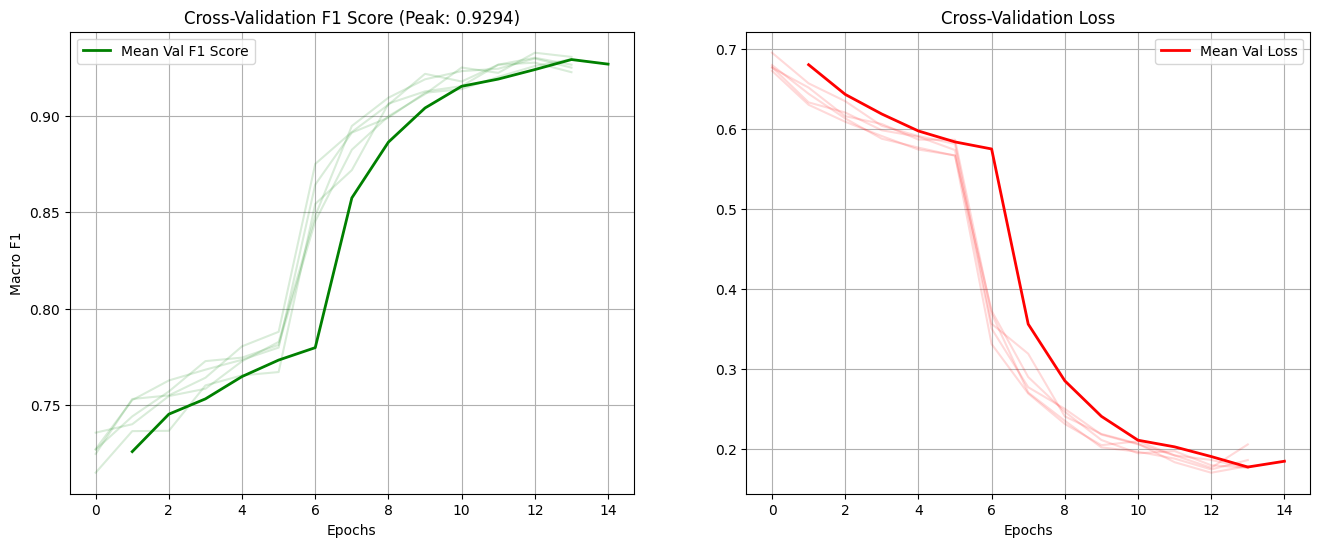

In [23]:
# Model Evaluation F1 Performance
plot_f1_performance(fold_histories)

In [ ]:
# Submission

final_predictions = test_predictions_sum / N_FOLDS
submission_df['task4'] = np.argmax(final_predictions, axis=1)
submission_df[['id', 'task4']].to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv
